# Missing Values

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# !pip install missingno
import missingno as msno
from datetime import date
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler

pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
pd.set_option("display.float_format", lambda x: '%.3f' % x)
pd.set_option("display.width", 500)

In [2]:
def load_application_train():
    data = pd.read_csv("datasets/application_train.csv")
    return data

In [3]:
def load():
    data = pd.read_csv("datasets/titanic.csv")
    return data

In [4]:
def catch_outliers(dataframe, num_col, q1=0.25, q3=0.75):
    quartile1 = dataframe[num_col].quantile(q1)
    quartile3 = dataframe[num_col].quantile(q3)
    iqr = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * iqr
    low_limit = quartile1 - 1.5 * iqr

    # outliers = [dataframe[(dataframe[num_col] < low) | (dataframe[num_col] > up)]]
    return low_limit, up_limit


def check_outlier(dataframe, num_col):
    low_limit, up_limit = catch_outliers(dataframe, num_col)

    if dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].any(axis=None):
        return True
    else:
        return False

    
def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    Veri setindeki kategorik, numerik ve kategorik fakat kardinal değişkenlerin isimlerini verir.

    Parameters
    ----------
    dataframe: dataframe
        Değişken isimleri alınmak istenen dataframe'dir.
    cat_th: int, float
        Numerik fakat kategorik olan değişkenler için sınıf eşik değeri.
    car_th: int, float
        Kategorik fakat kardinal değişkenler için sınıf eşik değeri.

    Returns
    -------
    cat_cols: list
        Kategorik değişken listesi.
    num_cols: list
        Numerik değişken listesi.
    cat_but_car: list
        Kategorik görünümlü kardinal değişken listesi.

    Notes
    ------
    cat_cols + num_cols + cat_but_car = toplam değişken sayısı
    num_but_cat, cat_cols'un içerisinde.

    """

    # cat_cols, cat_but_car
    cat_cols = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category", "bool"]]

    num_but_cats = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"] and
                    dataframe[col].nunique() < cat_th]

    cat_but_cars = [col for col in dataframe.columns if str(dataframe[col].dtypes) in ["object", "category"] and
                    dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cats

    cat_cols = [col for col in cat_cols if col not in cat_but_cars]

    # num_cols
    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes in ["int64", "float64"]]
    num_cols = [col for col in num_cols if col not in num_but_cats]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f"cat_cols: {len(cat_cols)}")
    print(f"num_cols: {len(num_cols)}")
    print(f"cat_but_car: {len(cat_but_cars)}")
    print(f"num_but_cat: {len(num_but_cats)}")

    return cat_cols, num_cols, cat_but_cars


def reach_outliers(dataframe, num_col, index=False):
    up_limit, low_limit = catch_outliers(dataframe, num_col)

    if len(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)]) > 10:
        print(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].head())
    else:
        print(dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)])

    if index:
        return dataframe[(dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit)].index


def remove_outliers(dataframe, num_col):
    up_limit, low_limit = catch_outliers(dataframe, num_col)
    df_without_outliers = dataframe[~((dataframe[num_col] < low_limit) | (dataframe[num_col] > up_limit))]

    return df_without_outliers


def replace_with_thresholds(dataframe, num_col):
    low_limit, up_limit = catch_outliers(dataframe, num_col)

    dataframe.loc[(dataframe[num_col] < low_limit), num_col] = low_limit
    dataframe.loc[(dataframe[num_col] > up_limit), num_col] = up_limit

## Eksik Değerlerin Yakalanması

In [5]:
df = load()

In [6]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S


In [7]:
# eksik gözlem var mı yok mu sorgusu
df.isnull().values.any()

True

In [8]:
# değişkenlerdeki eksik değer sayısı
df.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [9]:
# değişkenlerdeki dolu değer sayısı
df.notnull().sum()

PassengerId    891
Survived       891
Pclass         891
Name           891
Sex            891
Age            714
SibSp          891
Parch          891
Ticket         891
Fare           891
Cabin          204
Embarked       889
dtype: int64

In [10]:
# veri setindeki toplam eksik değer sayısı
df.isnull().sum().sum()

866

In [11]:
# en az bir tane eksik değere sahip olan satırlar (gözlem birimleri)
df[df.isnull().any(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.458,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000,3,1,349909,21.075,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000,0,2,347742,11.133,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000,1,0,237736,30.071,NaN,C
12,13,0,3,"Saundercock, Mr. William Henry",male,20.000,0,0,A/5. 2151,8.050,NaN,S
13,14,0,3,"Andersson, Mr. Anders Johan",male,39.000,1,5,347082,31.275,NaN,S
14,15,0,3,"Vestrom, Miss. Hulda Amanda Adolfina",female,14.000,0,0,350406,7.854,NaN,S


In [12]:
# eksik değer bulundurmayan satırlar (gözlem birimleri)
df[df.notnull().all(axis=1)]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.000,1,1,PP 9549,16.700,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.000,0,0,113783,26.550,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.000,0,0,248698,13.000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.000,0,0,113788,35.500,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000,1,0,PC 17572,76.729,D33,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C


In [13]:
# değişkenlerdeki eksiklik miktarlarını azalan şekilde sıralamak
df.isnull().sum().sort_values(ascending=False)

Cabin          687
Age            177
Embarked         2
Fare             0
Ticket           0
Parch            0
SibSp            0
Sex              0
Name             0
Pclass           0
Survived         0
PassengerId      0
dtype: int64

In [14]:
# değişkenlerdeki eksiklik miktarılarını yüzdelik olarak almak, oranlarını almak
(df.isnull().sum() / len(df) * 100).sort_values(ascending=False)

Cabin         77.104
Age           19.865
Embarked       0.224
Fare           0.000
Ticket         0.000
Parch          0.000
SibSp          0.000
Sex            0.000
Name           0.000
Pclass         0.000
Survived       0.000
PassengerId    0.000
dtype: float64

Yukarıdaki oranlara bakıldığında Cabin değişkenin %77'si ve Age değişkeninin yaklaşık %20'si eksikmiş.

In [15]:
# sadece eksik değer bulunduran değişkenlerin getirilmesi, eksik değer olmayan değişkenleri görmek istemiyoruz
na_cols = [col for col in df.columns if df[col].isnull().sum() > 0]

In [16]:
na_cols

['Age', 'Cabin', 'Embarked']

Şimdi yukarıdaki işlemleri otomatikleştirmek için bu işlemleri içeren bir fonksiyon hazırlayalım.

In [17]:
def missing_values_table(dataframe, na_name=False):
    # eksik veri bulunduran değişkenlerin seçilmesi
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]
    
    # değişkenlerdeki eksik değer miktarı
    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)
    # değişkenlerdeki eksik değer oranı
    ratio = (dataframe[na_columns].isnull().sum() / len(dataframe) * 100).sort_values(ascending=False)
    
    # yukardaki hesapladığımız miktar ve oran bilgilerini içeren bir df oluşturulması
    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])
    
    print(missing_df, end='\n')
    
    if na_name:
        return na_columns

In [18]:
missing_values_table(df, True)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


['Age', 'Cabin', 'Embarked']

Yukarıdaki çıktıyı incelediğimizde; df içerisinde eksik değer bulunduran üç tane değişken varmış. Örnek olarak Cabin değişkeninin eksik değer frekansı 687, oranı %77.1 miş.

## Eksik Değer Problemini Çözme

In [19]:
missing_values_table(df)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


Üç tane değişkende eksikliğimiz var ve bu eksiklikleri gidermek istiyoruz.

<b> Dikkat! Eğer ağaca dayalı yöntemler kullanılıyorsa bu durumda eksik değerler tıpkı aykırı değerlerdeki gibi etkisi göz ardı edilebilir durumlardır. </b>

### Çözüm 1: Hızlıca Silmek

In [20]:
df.dropna()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S
10,11,1,3,"Sandstrom, Miss. Marguerite Rut",female,4.000,1,1,PP 9549,16.700,G6,S
11,12,1,1,"Bonnell, Miss. Elizabeth",female,58.000,0,0,113783,26.550,C103,S
21,22,1,2,"Beesley, Mr. Lawrence",male,34.000,0,0,248698,13.000,D56,S
23,24,1,1,"Sloper, Mr. William Thompson",male,28.000,0,0,113788,35.500,A6,S
27,28,0,1,"Fortune, Mr. Charles Alexander",male,19.000,3,2,19950,263.000,C23 C25 C27,S
52,53,1,1,"Harper, Mrs. Henry Sleeper (Myna Haxtun)",female,49.000,1,0,PC 17572,76.729,D33,C
54,55,0,1,"Ostby, Mr. Engelhart Cornelius",male,65.000,0,1,113509,61.979,B30,C


In [21]:
df.dropna().shape

(183, 12)

Gözlem birimi miktarı çok fazla düştü. Bunun nedeni o gözlem biriminde bir tane bile NA değer varsa o birim df'den silinir. Çok yüksek boyutlu verisetlerinde, örnek olarak 500000 gözlem birimi bulunduran veri setinde 1000, 2000 birimde eksik değer varsa bu değerler silinebilir. Fakat az sayıda gözlem birimi bulunduran verisetlerinde dikkat edilmesi gerekir.

### Çözüm 2: Basit Atama Yöntemleri ile Doldurmak 

Örneğin yaş değişkenindeki eksik değerleri yaş değişkeninin <b>ortalaması</b> ile doldurmak istersek;

In [22]:
df["Age"].mean()

29.69911764705882

In [23]:
df["Age"].fillna(df["Age"].mean())

0     22.000
1     38.000
2     26.000
3     35.000
4     35.000
5     29.699
6     54.000
7      2.000
8     27.000
9     14.000
10     4.000
11    58.000
12    20.000
13    39.000
14    14.000
15    55.000
16     2.000
17    29.699
18    31.000
19    29.699
20    35.000
21    34.000
22    15.000
23    28.000
24     8.000
25    38.000
26    29.699
27    19.000
28    29.699
29    29.699
30    40.000
31    29.699
32    29.699
33    66.000
34    28.000
35    42.000
36    29.699
37    21.000
38    18.000
39    14.000
40    40.000
41    27.000
42    29.699
43     3.000
44    19.000
45    29.699
46    29.699
47    29.699
48    29.699
49    18.000
50     7.000
51    21.000
52    49.000
53    29.000
54    65.000
55    29.699
56    21.000
57    28.500
58     5.000
59    11.000
60    22.000
61    38.000
62    45.000
63     4.000
64    29.699
65    29.699
66    29.000
67    19.000
68    17.000
69    26.000
70    32.000
71    16.000
72    21.000
73    26.000
74    32.000
75    25.000
76    29.699

Age değişkenindeki eksik değerleri yaş'ın ortalaması ile doldurmuş olduk. Verisetinin ana yapısını bozmak istemediğim için bunu kaydetmedim.

<b>Medyan</b> değeri ile doldurabiliriz.

In [24]:
df["Age"].fillna(df["Age"].median())

0     22.000
1     38.000
2     26.000
3     35.000
4     35.000
5     28.000
6     54.000
7      2.000
8     27.000
9     14.000
10     4.000
11    58.000
12    20.000
13    39.000
14    14.000
15    55.000
16     2.000
17    28.000
18    31.000
19    28.000
20    35.000
21    34.000
22    15.000
23    28.000
24     8.000
25    38.000
26    28.000
27    19.000
28    28.000
29    28.000
30    40.000
31    28.000
32    28.000
33    66.000
34    28.000
35    42.000
36    28.000
37    21.000
38    18.000
39    14.000
40    40.000
41    27.000
42    28.000
43     3.000
44    19.000
45    28.000
46    28.000
47    28.000
48    28.000
49    18.000
50     7.000
51    21.000
52    49.000
53    29.000
54    65.000
55    28.000
56    21.000
57    28.500
58     5.000
59    11.000
60    22.000
61    38.000
62    45.000
63     4.000
64    28.000
65    28.000
66    29.000
67    19.000
68    17.000
69    26.000
70    32.000
71    16.000
72    21.000
73    26.000
74    32.000
75    25.000
76    28.000

<b>Sabit</b> bir değer ile doldurabiliriz.

In [25]:
df["Age"].fillna(0)

0     22.000
1     38.000
2     26.000
3     35.000
4     35.000
5      0.000
6     54.000
7      2.000
8     27.000
9     14.000
10     4.000
11    58.000
12    20.000
13    39.000
14    14.000
15    55.000
16     2.000
17     0.000
18    31.000
19     0.000
20    35.000
21    34.000
22    15.000
23    28.000
24     8.000
25    38.000
26     0.000
27    19.000
28     0.000
29     0.000
30    40.000
31     0.000
32     0.000
33    66.000
34    28.000
35    42.000
36     0.000
37    21.000
38    18.000
39    14.000
40    40.000
41    27.000
42     0.000
43     3.000
44    19.000
45     0.000
46     0.000
47     0.000
48     0.000
49    18.000
50     7.000
51    21.000
52    49.000
53    29.000
54    65.000
55     0.000
56    21.000
57    28.500
58     5.000
59    11.000
60    22.000
61    38.000
62    45.000
63     4.000
64     0.000
65     0.000
66    29.000
67    19.000
68    17.000
69    26.000
70    32.000
71    16.000
72    21.000
73    26.000
74    32.000
75    25.000
76     0.000

Nümerik değişkenlerdeki eksiklikleri o değişkenin ortalaması ile dolduran fonksiyon:

In [26]:
df.apply(lambda x: x.fillna(x.mean()) if x.dtype != 'O' else x, axis=0)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
5,6,0,3,"Moran, Mr. James",male,29.699,0,0,330877,8.458,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000,3,1,349909,21.075,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000,0,2,347742,11.133,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000,1,0,237736,30.071,NaN,C


Kategorik değişkenlerdeki eksik verileri o değişkenin mode'u ile dolduran fonksiyon:

<b>Dikkat! Kategorik olup unique değerleri max 10 olabilen değişkenler için uyguluyoruz!! Diğerleri kardinal oluyor onlara bir işlem yapmıyoruz.</b>

In [27]:
df.apply(lambda x: x.fillna(x.mode()) if (x.dtype == 'O' and len(x.unique()) <= 10) else x, axis=0)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.000,1,0,A/5 21171,7.250,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.000,1,0,PC 17599,71.283,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.000,0,0,STON/O2. 3101282,7.925,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.000,1,0,113803,53.100,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.000,0,0,373450,8.050,NaN,S
5,6,0,3,"Moran, Mr. James",male,nan,0,0,330877,8.458,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.000,0,0,17463,51.862,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.000,3,1,349909,21.075,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.000,0,2,347742,11.133,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.000,1,0,237736,30.071,NaN,C


### Kategorik Değişken Kırılımında Değer Atama

In [28]:
df.groupby("Sex")["Age"].mean()

Sex
female   27.916
male     30.727
Name: Age, dtype: float64

Yukarıdaki çıktıya baktığımızda kadınlar için ortalama yaş 27, erkekler için ortalama yaş 30muş. Ama biz genel olarak yaş ortalaması aldığımızda 29 çıkmıştı:

In [29]:
df["Age"].mean()

29.69911764705882

Age değişkeninde na değerleri bu genel ortalama ile doldurmuştuk. Bunun yerine eksik değerleri cinsiyeti kadın olan gözlem biriminde varsa kadınların yaş ortalamasıyla, cinsiyeti erkek olan gözlem biriminde varsa erkeklerin yaş ortalamasıyla doldurmak daha mantıklı olacaktır.

In [30]:
df["Age"].fillna(df.groupby("Sex")["Age"].transform("mean"))

0     22.000
1     38.000
2     26.000
3     35.000
4     35.000
5     30.727
6     54.000
7      2.000
8     27.000
9     14.000
10     4.000
11    58.000
12    20.000
13    39.000
14    14.000
15    55.000
16     2.000
17    30.727
18    31.000
19    27.916
20    35.000
21    34.000
22    15.000
23    28.000
24     8.000
25    38.000
26    30.727
27    19.000
28    27.916
29    30.727
30    40.000
31    27.916
32    27.916
33    66.000
34    28.000
35    42.000
36    30.727
37    21.000
38    18.000
39    14.000
40    40.000
41    27.000
42    30.727
43     3.000
44    19.000
45    30.727
46    30.727
47    27.916
48    30.727
49    18.000
50     7.000
51    21.000
52    49.000
53    29.000
54    65.000
55    30.727
56    21.000
57    28.500
58     5.000
59    11.000
60    22.000
61    38.000
62    45.000
63     4.000
64    30.727
65    30.727
66    29.000
67    19.000
68    17.000
69    26.000
70    32.000
71    16.000
72    21.000
73    26.000
74    32.000
75    25.000
76    30.727

Yukarıda, cinsiyet kırılımında ortalama yaş bilgilerini aldık. transform metodu ile de fillna metodunun cinsiyete göre ortalamayı yakalamasını sağladık.

Yukarıdaki kodun daha açık halini yazalım:

In [31]:
# loc metodu ile cinsiyeti kadın olanların yaş bilgisi eksik olan satırları getirilir
# bu satırları da cinsiyet kırılımında yaş ortalamalarından kadın kısmına eşitleyerek 
# kadınlar için eksik olan yaş değişkenine kadınların yaş ortalamarını atadık
df.loc[(df["Age"].isnull()) & (df["Sex"] == "female"), "Age"] = df.groupby("Sex")["Age"].mean()["female"]

In [32]:
# şimdi aynı işlemi erkekler için de yapalım
df.loc[(df["Age"].isnull()) & (df["Sex"] == "male"), "Age"] = df.groupby("Sex")["Age"].mean()["male"]

### Çözüm 3: Tahmine Dayalı Atama ile Doldurma

Burada tahmin elde edebilmemiz için makine öğrenmesi modeli kurmamız gerekli. Bundan dolayı model kurabilmek için gerekli tüm işlemleri gerçekleştirmemiz gerekli.

In [33]:
df = load()

In [34]:
cat_cols, num_cols, cat_but_car = grab_col_names(df)

Observations: 891
Variables: 12
cat_cols: 6
num_cols: 3
cat_but_car: 3
num_but_cat: 4


In [35]:
num_cols = [col for col in num_cols if col not in "PassengerId"]

In [36]:
num_cols

['Age', 'Fare']

Kategorik değişkenlerin encode işlemleri:

In [37]:
cat_cols

['Sex', 'Embarked', 'Survived', 'Pclass', 'SibSp', 'Parch']

In [38]:
dff = pd.get_dummies(df[cat_cols + num_cols], drop_first=True)
#cat_cols ve num_cols listelerini birleştirdik ve cat_colslardaki kategorik değişkenleri nümerik değişkenlere dönüştürdük.
#nümerik değişkene dönüştürülen kategorik değişkenleri de drop ettik (drop_first sayesinde)

In [39]:
dff.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0,3,1,0,22.000,7.250,1,0,1
1,1,1,1,0,38.000,71.283,0,0,0
2,1,3,0,0,26.000,7.925,0,0,1
3,1,1,1,0,35.000,53.100,0,0,1
4,0,3,0,0,35.000,8.050,1,0,1


Scale işlemi:

In [40]:
scaler = MinMaxScaler()

In [41]:
dff = pd.DataFrame(scaler.fit_transform(dff), columns=dff.columns)

In [42]:
dff.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.000,1.000,0.125,0.000,0.271,0.014,1.000,0.000,1.000
1,1.000,0.000,0.125,0.000,0.472,0.139,0.000,0.000,0.000
2,1.000,1.000,0.000,0.000,0.321,0.015,0.000,0.000,1.000
3,1.000,0.000,0.125,0.000,0.435,0.104,0.000,0.000,1.000
4,0.000,1.000,0.000,0.000,0.435,0.016,1.000,0.000,1.000


Na değerleri doldrumak için knn imputer metodunu kullanacağız:

In [43]:
from sklearn.impute import KNNImputer

In [44]:
imputer = KNNImputer(n_neighbors=5)

In [45]:
dff = pd.DataFrame(imputer.fit_transform(dff), columns=dff.columns)

In [46]:
dff.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.000,1.000,0.125,0.000,0.271,0.014,1.000,0.000,1.000
1,1.000,0.000,0.125,0.000,0.472,0.139,0.000,0.000,0.000
2,1.000,1.000,0.000,0.000,0.321,0.015,0.000,0.000,1.000
3,1.000,0.000,0.125,0.000,0.435,0.104,0.000,0.000,1.000
4,0.000,1.000,0.000,0.000,0.435,0.016,1.000,0.000,1.000


Boşlukları doldurduk fakat değerler scale edildiği için değeri okuyamıyoruz. Bundan dolayı scale işlemini geri almamız gerekli.

In [47]:
dff = pd.DataFrame(scaler.inverse_transform(dff), columns=dff.columns)

In [48]:
dff.head()

,Survived,Pclass,SibSp,Parch,Age,Fare,Sex_male,Embarked_Q,Embarked_S
0,0.000,3.000,1.000,0.000,22.000,7.250,1.000,0.000,1.000
1,1.000,1.000,1.000,0.000,38.000,71.283,0.000,0.000,0.000
2,1.000,3.000,0.000,0.000,26.000,7.925,0.000,0.000,1.000
3,1.000,1.000,1.000,0.000,35.000,53.100,0.000,0.000,1.000
4,0.000,3.000,0.000,0.000,35.000,8.050,1.000,0.000,1.000


Şimdi biz bu değerleri atadık ama hangi boş değer yerine hangi değer atandı bunları göremiyoruz. Eğer bunları görmek istersek ilk df'i de kullanarak:

In [49]:
df["age_imputed_knn"] = dff[["Age"]]

In [50]:
df.loc[df["Age"].isnull(), ["Age", "age_imputed_knn"]]

,Age,age_imputed_knn
5,nan,47.800
17,nan,37.600
19,nan,12.200
26,nan,32.800
28,nan,17.600
29,nan,24.400
31,nan,29.600
32,nan,17.600
36,nan,21.800
42,nan,28.700


## Eksik Verinin Yapısını İncelemek

Burada eksik verinin yapısını, bağımlılık durumu olup olmamasını inceleyeceğiz.

### Eksik Verinin Yapısının İncelenmesi

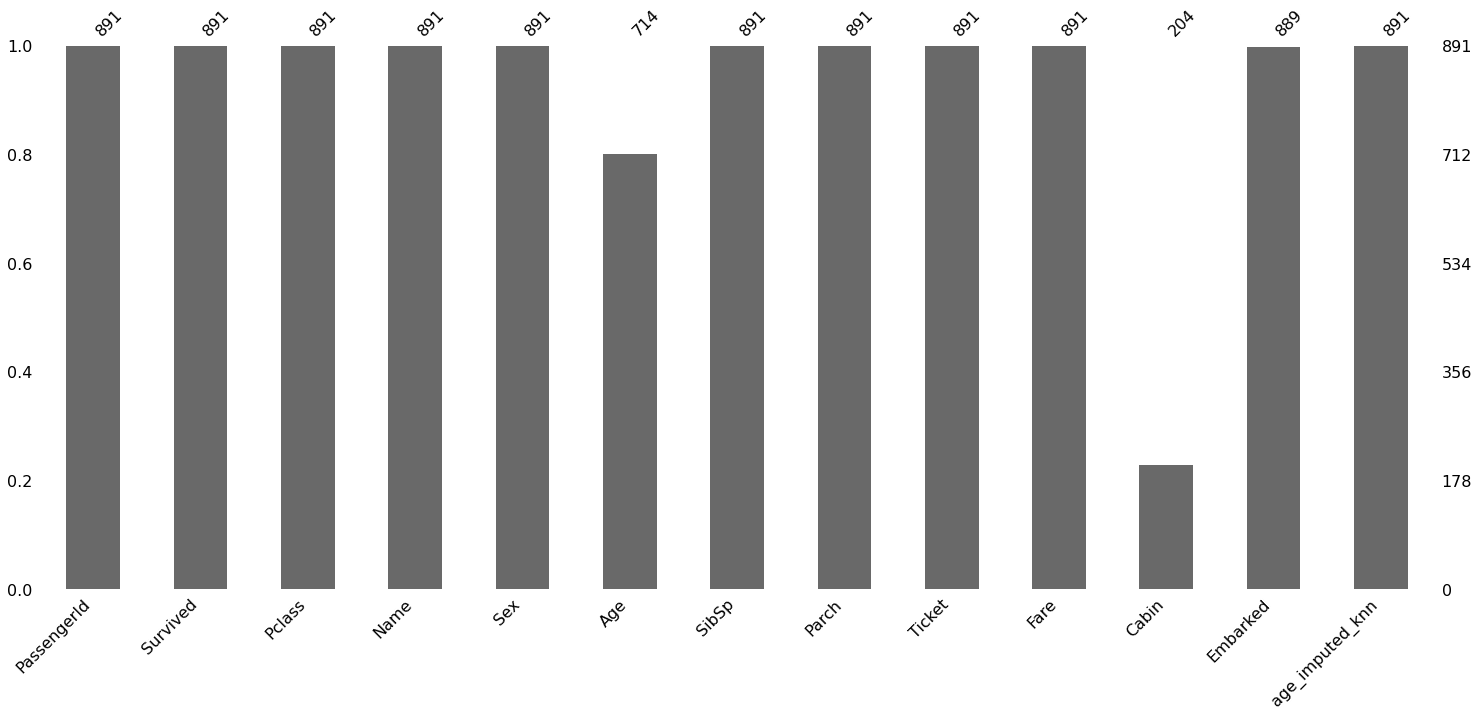

In [51]:
msno.bar(df)
plt.show()

Bu grafik, dataframe içerisindeki değişkenlerin dolu değerlerini göstermektedir.

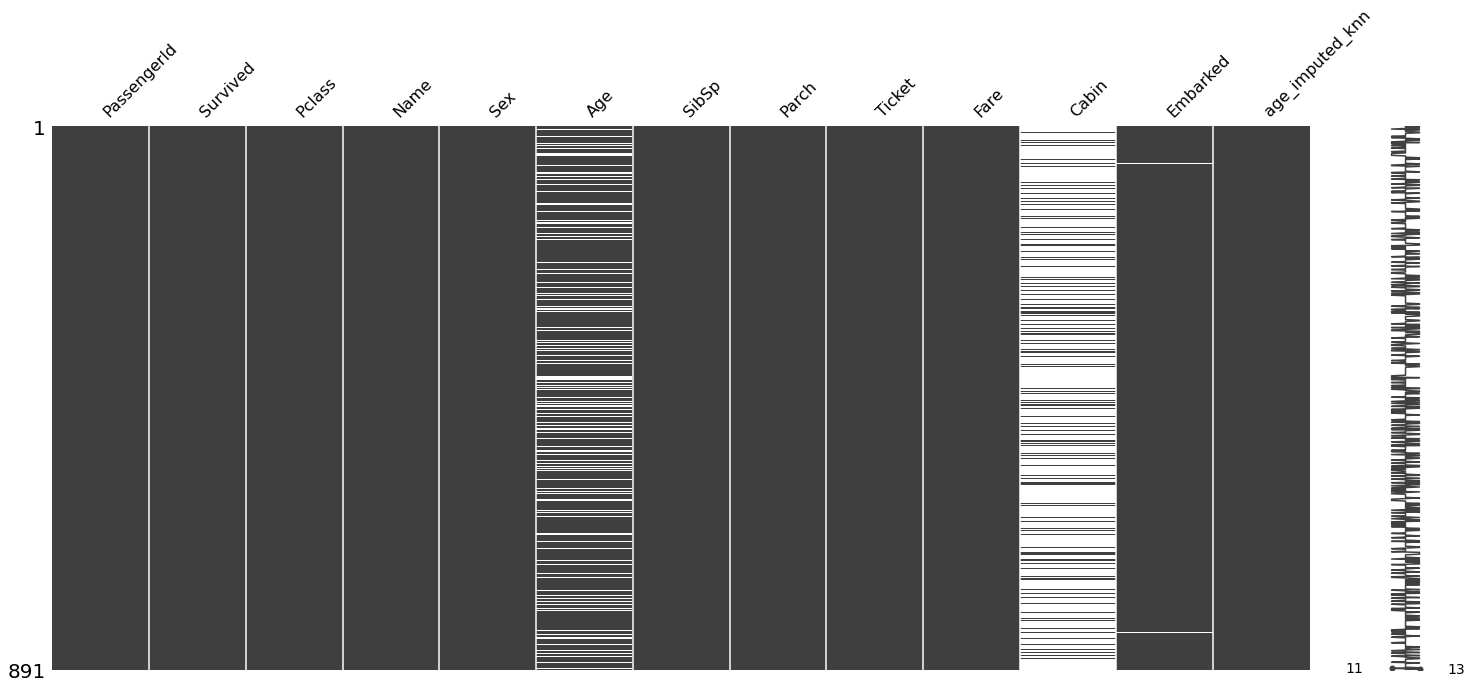

In [53]:
msno.matrix(df)
plt.show()

Değişkenlerdeki eksikliklerin bir araya çıkıp çıkmama durumunu incelemek için görsel bir araçtır. Burada eğer değişkenlerdeki eksiklikler birarada meydana geliyorsa. Eğer iki değişken arasında bir bağıntı olsaydı, o değişkendeki beyazlıklar yani boşluklar diğer değişkende de benzer şekilde oluşurdu. Burada herhangi bir bağlantının olmadığı görülür.

Özetle bu grafik teknik, değişkenlerdeki eksikliklerin birlikte çıkıp çıkmadığıyla ilgili bir bilgi verir.

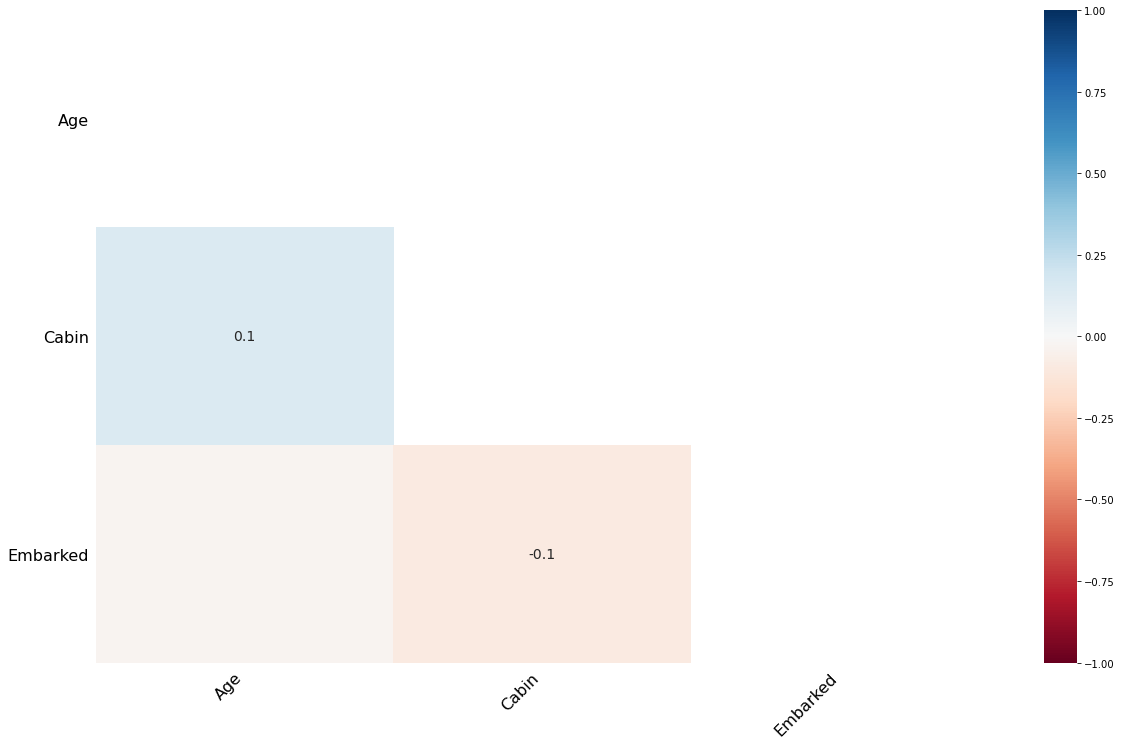

In [55]:
msno.heatmap(df)
plt.show()

Bu grafikte değişkenler sağdaki aralıkta pozitif yönde kuvvetli ilişki ve negatif yönlü kuvvetli ilişki aralığında değerler alır. Pozitif yönlü kuvvetli ilişki olması durumunda değişkenlerdeki eksikliklerin birlikte ortaya çıktığı düşünülür. Yani birisinde eksik varken diğerinde de vardır, birisinde yokken diğerinde de yoktur. Eğer negatif bir korelasyon varsa bu sefer birisinde varken diğerinde yok, birisinde yokken diğerinde vardır şeklinde bir ilişki vardır. 

Bizim senaryomuzda 0.1 ve -0.1 gibi iki korelasyon değeri bulunmuş. Bu ikisi dikkate alınmayacak derecede anlamsız korelasyonlardır. Eğer 0.6 ve üzeri değer çıkarsa o zaman o iki değişkendeki eksikliklerin birlikte ortaya çıkmış olabileceğinden şüphelenebilirdik.

## Eksik Değerlerin Bağımlı Değişken ile Analizi

Verisetimizdeki eksikliklerin acaba bağımlı değişken tarafında bir karşılığı var mı?

Öncelikle eksik değere sahip değişkenleri çekelim:

In [57]:
na_cols = missing_values_table(df, na_name=True)

          n_miss  ratio
Cabin        687 77.100
Age          177 19.870
Embarked       2  0.220


In [58]:
na_cols

['Age', 'Cabin', 'Embarked']

In [59]:
def missing_vs_target(dataframe, target, na_columns):
    temp_df = dataframe.copy() #dataframe'in kopyasını oluşturduk. Bunun üzerinden işlem yapacağız.
    
    for col in na_columns: # daha önceden belirlediğimiz na içeren değişkenlerin bulunduğu listede gez
        # bu değişkenler içerisinde na gördüğün yere 1 diğerlerine 0 yaz, bu değişkenleri de ismine na_flag ifadesini ekleyerek al
        temp_df[col + '_NA_FLAG'] = np.where(temp_df[col].isnull(), 1, 0)
    
    # temp_df içerisinde '_NA_' stringini içeren değişkenleri al, na_flags'e ata.
    na_flags = temp_df.loc[:, temp_df.columns.str.contains('_NA_')].columns
    
    for col in na_flags: # na_flags içerisinde gez
        print(pd.DataFrame({"TARGET_MEAN": temp_df.groupby(col)[target].mean(),
                           "Count": temp_df.groupby(col)[target].count()}), end="\n\n\n")
        # na içeren değişkenlerin kırılımında bağımlı değişkenin (target'in) ortalamasını ve toplamını içeren bir df oluştur

In [60]:
missing_vs_target(df, "Survived", na_cols)

             TARGET_MEAN  Count
Age_NA_FLAG                    
0                  0.406    714
1                  0.294    177


               TARGET_MEAN  Count
Cabin_NA_FLAG                    
0                    0.667    204
1                    0.300    687


                  TARGET_MEAN  Count
Embarked_NA_FLAG                    
0                       0.382    889
1                       1.000      2




Buradaki çıktıda her bir na içeren değişken içerisinde; 1 -> na olan değerler, 0 -> dolu olan değerler. Her iki durum için de ortalama hayatta kalma oranları ve o durumda toplam kaç gözlem var onun sayısını veriyor. 

Cabin değişkeni içerisinde na değerleri olan 687 tane gözlem birimi bulunuyormuş ve bunların içerisinden %30'u hayatta kalmış. Bu yüksek bir oran ve çok değerli bir bilgi çünkü burada Cabin değişkeni içerisindeki na ifadeler bağımlı değişken için anlam ifade ediyor gibi gözüküyor.